# Gradient Descent, SGD, and Ridge Regression

To start with, let's load the toy dataset and do some preparation.

In [2]:
%matplotlib inline

import os,sys
import numpy as np
import pandas as pd
import logging
import time
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split

# Feature Normalization
def feature_normalization(train, test):
    """
    Rescale the data so that each feature in the training set is in
    the interval [0,1], and apply the same transformations to the test
    set, using the statistics computed on the training set.
    """
    # Get the statistics of the dataset
    trainMin = np.min(train,0)
    trainMax = np.max(train,0)
    
    # Omit the features that have constant values
    equal_feat_index = (trainMax != trainMin)
    train = train[:, equal_feat_index]
    test = test[:, equal_feat_index]
    trainMax = trainMax[equal_feat_index]
    trainMin = trainMin[equal_feat_index]
    
    # Normalize
    train_normalized = (train - trainMin) / (trainMax - trainMin)
    test_normalized = (test - trainMin) / (trainMax - trainMin)
    
    return train_normalized, test_normalized

In [3]:
#Loading the dataset
print("Loading the dataset...")

df = pd.read_csv('hw1-data.csv', delimiter=',')
X = df.values[:,:-1]
y = df.values[:,-1]

print("Split into Train and Test...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =100, random_state=10)

print("Scaling all to [0, 1]...")
X_train, X_test = feature_normalization(X_train, X_test)
X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1))))  # Add bias term
X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1)))) # Add bias term

print("Dataset ready!")

Loading the dataset...
Split into Train and Test...
Scaling all to [0, 1]...
Dataset ready!


## 1. Solving Linear Regression with Gradient Descent

### 1.1 Gradient Descent Setup

In linear regression, the hypothesis space of linear function is $$h(x)=\theta^{T}x, \text{ where } \theta, x\in\mathbf{R}^d$$

we want to find $\theta$ that minimizes the following "square loss" objective function

$$
J(\theta)
=\frac{1}{2n}\sum_{i=1}^{n}(h_{\theta}(x_{i})-y_{i})^2
=\frac{1}{2n}(X\theta-y)^T(X\theta-y)
$$

where $(x_1, y_1), ..., (x_n, y_n)\in\mathbf{R}^d\times\mathbf{R}$ is our training data.

So we can compute the gradient of $J$ as:
$$\nabla_{\theta}J(\theta)=\frac{1}{n}X^T(X\theta-y)$$

In [4]:
# The square loss function
def compute_square_loss(X, y, theta):
    num_instances = X.shape[0]
    temp = np.dot(X, theta) - y
    loss = 0.5/num_instances * np.dot(temp.T, temp)    
    return loss

# compute the gradient of square loss function
def compute_square_loss_gradient(X, y, theta):
    num_instances = X.shape[0]
    grad = 1 / num_instances * np.dot(X.T, (np.dot(X, theta) - y))
    return grad


### 1.2 Gradient Checker

Coding up the gradient correctly can be tricky for some optimization problems. However, we can check the gradient calculation by some approximation. 

If $J:\mathbf{R}^d\rightarrow\mathbf{R}$ is differentiable, then for any direction vector $\Delta\in\mathbf{R}^d$, the directional derivative of $J$ at $\theta$ in the direction $\Delta$ is given by 

$$
\lim_{\varepsilon\rightarrow{0}}\frac{J(\theta+\varepsilon\Delta)-J(\theta-\varepsilon\Delta)}{2\varepsilon}
$$

We can approximate this directional derivative by choosing a small value of $\varepsilon > 0$ and evaluating the quotient above. We can get an approximation to the gradient by approximating the directional derivatives in each coordinate direction and putting them together into a vector. (More details on [gradient checking](http://ufldl.stanford.edu/wiki/index.php/Gradient_checking_and_advanced_optimization).)

In [5]:
# Gradient Checker
def grad_checker(X, y, theta, epsilon=0.01, tolerance=1e-4): 

    true_gradient = compute_square_loss_gradient(X, y, theta) #the true gradient
    num_features = theta.shape[0]
    approx_grad = np.zeros(num_features) #Initialize the gradient we approximate
    e = np.eye(num_features)
    for i in range(num_features):
        approx_grad[i] = (compute_square_loss(X, y, theta+epsilon*e[i]) - compute_square_loss(X, y, theta-epsilon*e[i])) / (2*epsilon)
    dist = true_gradient - approx_grad
    return (np.sqrt(np.dot(dist.T, dist)) < tolerance)

# Generic Gradient Checker - works for any objective function
def generic_gradient_checker(X, y, theta, objective_func, gradient_func, epsilon=0.01, tolerance=1e-4):
    """
    The functions takes objective_func and gradient_func as parameters. And check whether gradient_func(X, y, theta) returned
    the true gradient for objective_func(X, y, theta).
    Eg: In LSR, the objective_func = compute_square_loss, and gradient_func = compute_square_loss_gradient
    """
    true_gradient = gradient_func(X, y, theta) #the true gradient
    num_features = theta.shape[0]
    approx_grad = np.zeros(num_features) #Initialize the gradient we approximate
    
    e = np.eye(num_features)
    for i in range(num_features):
        approx_grad[i] = (objective_func(X, y, theta+epsilon*e[i]) - objective_func(X, y, theta-epsilon*e[i])) / (2*epsilon)
    dist = true_gradient - approx_grad
    return (np.sqrt(np.dot(dist.T, dist)) < tolerance)


### 1.3 Batch Gradient Descent

Now we are implementing the Batch Gradient Descent method and we will try it out after we load the data.

In [6]:
def batch_grad_descent(X, y, alpha=0.1, num_iter=1000, check_gradient=False):

    num_instances, num_features = X.shape[0], X.shape[1]
    theta_hist = np.zeros((num_iter+1, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_iter+1) #initialize loss_hist
    theta = np.ones(num_features) #initialize theta
    
    for i in range(num_iter):
        theta_hist[i] = theta
        loss_hist[i] = compute_square_loss(X, y, theta)
        #theta = theta - alpha * compute_square_loss_gradient(X, y, theta)  # correct?
        grad = compute_square_loss_gradient(X, y, theta)
        if check_gradient:
            if not grad_checker(X, y, theta):
                sys.exit("Wrong gradient!")
        if alpha == "stepsize_search":
            step_size = stepsize_search(X, y, theta, compute_square_loss, 
                                        compute_square_loss_gradient)
        else:
            theta = theta - alpha * grad
    theta_hist[-1] = theta
    loss_hist[-1] = compute_square_loss(X,y,theta)
    
    return theta_hist, loss_hist


### 1.4 Experiment with Stepsize

Now let's run the Batch Gradient Descent with different step-sizes. If the step-size is too large, gradient descent may not converge; while if the step-size is too small, the loss would converge very slow. 

Batch gradient descend:


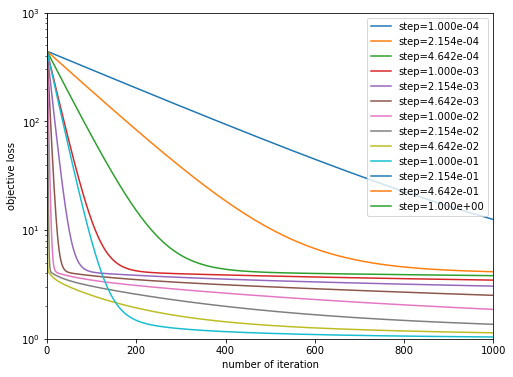

In [7]:
alpha_set = 10 ** np.linspace(-4, 0, num=13)

print("Batch gradient descend:")
loss_results = pd.DataFrame()
for alpha in alpha_set:
    coef, loss_results["step=" + "%.3e" % alpha] = batch_grad_descent(X_train, y_train, alpha=alpha)
loss_results.plot(figsize=(8,6))
plt.xlabel('number of iteration')
plt.ylabel('objective loss')
plt.ylim([1,10**3])
plt.yscale('log')
plt.savefig('compare_fix_bls.png', dpi=300)

We can see that `step_size`=0.1 outperforms the others.

### 1.5 Backtracking Line Search

How about we optimize our stepsize at each iteration rather than using a fixed stepsize? 

Backtracking line search is a method to determine the maximum amount to move along a given search direction. In gradient descent, after we have compute the gradient at current step, we go as much as we can along the direction of gradient descent, based on backtracking line search. 

In [8]:
def backtracking_line_search(X, y, num_iter=100, check_gradient=False):
    
    num_instances, num_features = X.shape[0], X.shape[1]
    theta_hist = np.zeros((num_iter+1, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_iter+1) #initialize loss_hist
    theta = np.ones(num_features) #initialize theta
    
    for i in range(num_iter):
        theta_hist[i] = theta
        loss_hist[i] = compute_square_loss(X, y, theta)
        alpha = stepsize_search(X,y,theta,compute_square_loss,compute_square_loss_gradient)
        theta = theta - alpha * compute_square_loss_gradient(X, y, theta)  # correct?
        
    theta_hist[-1] = theta
    loss_hist[-1] = compute_square_loss(X, y, theta)
    
    return theta_hist, loss_hist

# search for the optimal stepsize at each iteration
def stepsize_search(X, y, theta, loss_func, grad_func, epsilon=1e-6):
    alpha = 1.0
    gamma = 0.5
    loss = loss_func(X, y, theta)
    gradient = grad_func(X, y, theta)
    while True:
        theta_next = theta - alpha * gradient
        loss_next = loss_func(X, y, theta_next)
        if loss_next > loss - epsilon:
            alpha = alpha * gamma
        else:
            return alpha


So how is backtracking line search compared with fixed step-size?
Let's run both of these methods on our dataset:

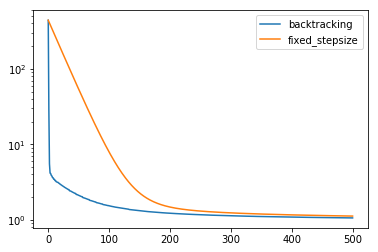

In [9]:
_, loss_bls = backtracking_line_search(X_train, y_train,num_iter=500)
_, loss_fix = batch_grad_descent(X_train,y_train,alpha=0.1,num_iter=500)
plt.plot(loss_bls)
plt.plot(loss_fix)
plt.yscale('log')
plt.legend(['backtracking','fixed_stepsize'])

We can see from above that backtracking line search converges in less iterations. But after large number of iterations, the gap between backtracking line search and fixed step-size is not that much.

## 2. Gradient Descent with Regularization 

### 2.1 Regularized Regression Setup

When the number of features is much larger than the number of training samples, we need to take some measures to avoid overfitting, such as regularization. Ridge regression is linear regression with $L_2$ regularization, with the following objective function:

$$
J(\theta)=\frac{1}{2n}\sum_{i=1}^{n}{(h_{\theta}(x_i)-y_i)^2}+\lambda\theta^T\theta
$$

where $\lambda$ is the regularization parameter that controls the degree of regularization. Now we need to compute the gradient of $J(\theta)$ as follows:

$$
\nabla_{\theta}J(\theta) = \frac{1}{n}X^T(X\theta-y)+2\lambda\theta
$$

In [10]:
# Compute the gradient of Regularized Batch Gradient Descent
def compute_regularized_square_loss_gradient(X, y, theta, lambda_reg):
    num_instances = X.shape[0]
    grad = 1 / num_instances * np.dot(X.T, (np.dot(X, theta) - y)) + lambda_reg * 2 * theta
    return grad

# Batch Gradient Descent with regularization
def regularized_grad_descent(X, y, alpha=0.1, lambda_reg=1, num_iter=1000):
    """
    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        alpha - step size in gradient descent
        lambda_reg - the regularization coefficient
        numIter - number of iterations to run 
        
    Returns:
        theta_hist - the history of parameter vector, 2D numpy array of size (num_iter+1, num_features) 
        loss_hist - the history of regularized loss value, 1D numpy array
    """
    (num_instances, num_features) = X.shape
    theta = np.ones(num_features) #Initialize theta
    theta_hist = np.zeros((num_iter+1, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_iter+1) #Initialize loss_hist
    for i in range(num_iter):
        theta_hist[i] = theta
        #loss_hist[i] = compute_square_loss(X, y, theta) + lambda_reg * np.dot(theta.T, theta)  # J(theta) with L2 regularization
        loss_hist[i] = compute_square_loss(X, y, theta)
        theta = theta - alpha * compute_regularized_square_loss_gradient(X, y, theta, lambda_reg)
    theta_hist[-1] = theta
    #loss_hist[-1] = compute_square_loss(X,y,theta) + lambda_reg * np.dot(theta.T, theta) 
    loss_hist[-1] = compute_square_loss(X,y,theta) # why without the penalty term?
    
    return theta_hist, loss_hist

### 2.2 Experiment with regularization parameter $\lambda$

How does gradient descent perform with different values of $\lambda$? Let's look at the train loss and test loss as a function of the regularization parameter. 

Ridge regression:


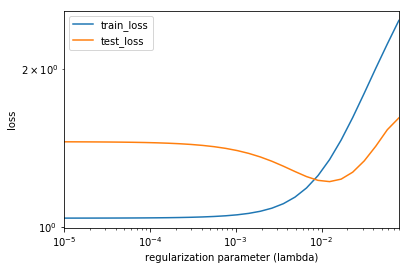

In [11]:
lambda_set = 10 ** np.linspace(-5, -1.1, 30)

print("Ridge regression:")
reg_loss_results = pd.DataFrame(columns=lambda_set)
square_loss = pd.DataFrame(index=lambda_set, columns=["train_loss","test_loss"])  # train_loss and test_loss
for lbda in lambda_set:
    theta_s, _ = regularized_grad_descent(X_train, y_train, alpha=0.1, lambda_reg=lbda)
    theta_star = theta_s[-1]
    square_loss["train_loss"][lbda] = compute_square_loss(X_train, y_train, theta_star)
    square_loss["test_loss"][lbda] = compute_square_loss(X_test, y_test, theta_star)
        
square_loss.plot()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('regularization parameter (lambda)')
plt.ylabel('loss')
plt.savefig('ridge_reg.png', dpi=300)

We want to find the $\theta$ that minimize the test loss, but can only refer to the performance of $\theta$ on training data. Based on the result above, we can see that L2 regularization can help reduce over-fitting to some extend; however, the regularization parameter $\lambda$ cannot be too large, or the objective function will diverge. If $\lambda$ is very small, the regularization is weak. Therefore, the coefficient vector $\theta^*$ obtained from ridge regression with $\lambda \approx 0.01$ is a good choice for deployment.

## 3. Stochastic Gradient Descent

### 3.1 Setup

Stochastic Gradient descent is an effective solution to large training data. At each step, compute the gradient at a single sample gives an unbiased estimation of the gradient of the objective function. 

In [12]:
def sgd(X,y,alpha=0.1,lambda_reg=1.0,num_iter=1000):
    num_instances, num_features = X.shape[0], X.shape[1]
    theta = np.ones(num_features) #Initialize theta
    theta_hist = np.zeros((num_iter, num_instances, num_features))  #Initialize theta_hist
    loss_hist = np.zeros((num_iter, num_instances)) #Initialize loss_hist
    
    s_order = np.arange(num_instances)
    step_num = 1.0
        
    for i in range(num_iter):
        np.random.shuffle(s_order)
        for j in range(num_instances):
            theta_hist[i][j] = theta
            loss_hist[i][j] = compute_square_loss(X,y,theta) #+ lambda_reg*np.dot(theta.T, theta)
            grad = (np.dot(X[s_order[j]], theta.T) - y[s_order[j]]) * X[s_order[j]] + lambda_reg*2*theta
            if isinstance(alpha, str):
                if alpha == '1/t':
                    alpha = 1./step_num 
                elif alpha == '1/sqrt(t)':
                    alpha = 1./np.sqrt(step_num)
                step_num += 1
            theta = theta - alpha * grad
    return theta_hist, loss_hist
    

### 3.2 Experiment with step-size for SGD

We are going to find the optimal $\theta^*$ using SGD with a few fixed step-size. Note that stochastic gradient descent might not converge with fixed step sizes. 


In [13]:
step_set = [1e-4, 1e-3, 5e-3, 1e-2, 5e-2]
loss_hist = pd.DataFrame()
for step in step_set:
    w, loss = sgd(X_train, y_train, alpha=step, lambda_reg=0.01, num_iter=1000)
    loss_hist["step="+"%.2e" % step] = loss[:,-1]   

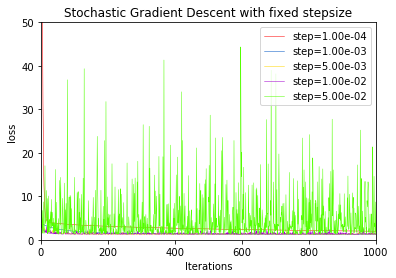

In [14]:
loss_hist.plot(linewidth=0.5,colormap='prism')
plt.ylim([0,50])
plt.xlabel("Iterations")
plt.ylabel("loss")
plt.title("Stochastic Gradient Descent with fixed stepsize")

### 3.3 SGD vs. GD

How is stochastic gradient descent compared with gradient descent?

(0, 5)

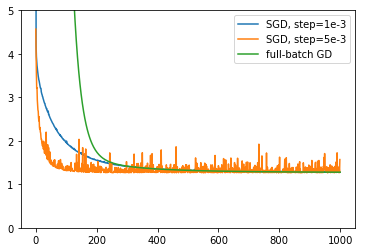

In [16]:
_, loss_batch = regularized_grad_descent(X_train,y_train,alpha=0.1,lambda_reg=0.01)
plt.plot(loss_hist['step=1.00e-03'])
plt.plot(loss_hist['step=5.00e-03'])
plt.plot(loss_batch)
plt.legend(['SGD, step=1e-3','SGD, step=5e-3','full-batch GD'])
plt.ylim([0,5])

Though the running time for SGD takes longer than GD, but it takes fewer iterations to converge for SGD. That's why SGD or mini-batch GD is much faster than GD to reach a point that's close enough to the minimum for very large datasets. 